## Exploratory Data Analysis of MTA Turnstile Data of New York City
By Mahfuz Miah, August 5, 2019

## 1. Synopsis
For this project, I performed some exploratory analysis on turnstile data of the subway/train system (MTA) of New York City. This dataset is titled NYS Turnstile Data Usage and comes from the New York State Open Data project. It is maintained and updated by Kaggle and can be retrieved at this link: [MTA_Turnstile_Data](https://www.kaggle.com/new-york-state/nys-turnstile-usage-data/). The dataset we have executed our code on was downloaded on July 3rd, 2019.

The goal of our project was to investigate usage patterns of one particular station, 14th Street - Union Square. To do so, I compared and tested three questions: (1) What are the most popular days that this station is used, in terms of entries and exits? (3) What is the distribution of entries and exits by day of week (3) how does traffic fluctuate throughout the week in terms of time of day?

## 2. Background
Below is an explanation of column headings from the document hosted by Kaggle named: Turnstile Usage Data Data Dictionary

C/A - Control Area name/Booth name. This is the internal identification of a booth at a given station.

Unit - Remote unit ID of station.

SCP - Subunit/Channel/position represents a specific address for a given device. 

STATION - Name assigned to the subway station by operations planning. This name is used in all references to stations, as well as in debit/credit purchase receipts, and customer’s bank activity statements.

LINENAME - Train lines stopping at this location. Can contain up to 20 single character identifier. When more than one train line appears, it is usually intercepting train lines, in major stations where the passenger can transfer between any one of the lines.

DIVISION - Represents the Line originally the station belonged to BMT, IRT, or IND. Each section of the system is assigned a unique line name, usually paired with its original operating company or division (Brooklyn–Manhattan Transit Corporation (BMT), Interborough Rapid Transit Company (IRT), and Independent Subway System (IND).

DATE - Represents the date of the audit data.

TIME - Represents the time of the reported data (HH:MM:SS). The normal interval between audit reports for the same device is 4 hours. The four hour intervals will differ from other stations due to the need for staggering to prevent flooding the system with audit readings all at once. Systemwide, stations have been set to begin audit transmittal between 00 to 03 hours, then every 4 hours after the first audit of the day. 

DESC - Represent the "REGULAR" scheduled audit event (Normally occurs every 4 hours) 1. Audits may occur more frequently than 4 hours due to planning, or troubleshooting activities. 2. Additionally, there may be a "RECOVR AUD" entry: This refers to a missed audit that was recovered. If a recovered audit is sent and is identical to the previous
register reading, it will be omitted. 

ENTRIES - The cumulative ENTRY register value for adevice. This register was initialized during system setup. It is a 10 digit number representing the number of entries on the specific device since its inception. Other forms of initialization may occur upon roll-over of the counter, erasing the memory device containing the register data, and replacing the processing device of the turnstile. 

EXITS - The cumulative EXITS register value for a device. This register was initialized during system setup. It is a 10 digit number representing the number of entries on the specific device since its inception. Other forms of initialization may occur upon roll-over of the counter, erasing the memory device containing the register data, and replacing the processing device of the turnstile. 


## 3. Understanding and Preparing the Data Set


In [43]:
# import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import statistics
import tkinter as tk
from textwrap import wrap
from tkinter import filedialog
from pandas import DataFrame
import datetime
import seaborn as sns
from scipy.signal import find_peaks


sns.set()

# set up the figure size

%matplotlib inline


In [2]:
# Set up the data

filename = 'turnstile-usage-data-2018.csv'
def setdata(filename):
    df = pd.read_csv(filename, parse_dates=['Date'])
    # Strip and make column names lowercase so that they are easy to manage. 
    df.columns = df.columns.str.strip().str.lower()

    # Replace characters or remove spaces and make all words lowercase.
    df.columns = df.columns.str.replace(' ', '_').str.replace('/', '_').str.replace('(', '').str.replace(')', '')

    # Sort data by C/A (equivalent to station), unit and scp (equivalent to a turnstile) 
    # and date and time (in descending order)
    df = df.sort_values(by=['c_a','unit', 'scp', 'date', 'time'],ascending = [True, True, True, False, False]).copy()
    return df

df = setdata(filename)
#Be aware, the file is big so this process will take some time.

In [3]:
# What's inside the file? Let's take a preview.
def whats_inside(df):
    print("Column values in dataframe: ", list(df.columns.values)) 
    print(df.describe())
    
whats_inside(df)
#We are still working with the full dataset so runtime is a bit high. We'll cut that down shortly.

Column values in dataframe:  ['c_a', 'unit', 'scp', 'station', 'line_name', 'division', 'date', 'time', 'description', 'entries', 'exits']
            entries         exits
count  1.011147e+07  1.011147e+07
mean   3.961658e+07  3.258595e+07
std    2.058149e+08  1.904601e+08
min    0.000000e+00  0.000000e+00
25%    4.929705e+05  2.377950e+05
50%    2.527592e+06  1.426439e+06
75%    6.916714e+06  4.814437e+06
max    2.144893e+09  2.146093e+09


Clearly there is too much data here; we have here approximately 10 million data points to work with. Perhaps we can benefit from looking at a subset of the data. Let's take a slice of our data.

In [4]:
#List of unique values in the df['name'] column
def uniqueval(df):
    column_names = list(df.columns.values)
    for column_name in column_names:
        print("There are " + str(df[column_name].nunique()) + " unique values in column \'" + column_name + "\'.")
uniqueval(df)

There are 749 unique values in column 'c_a'.
There are 470 unique values in column 'unit'.
There are 229 unique values in column 'scp'.
There are 379 unique values in column 'station'.
There are 114 unique values in column 'line_name'.
There are 6 unique values in column 'division'.
There are 350 unique values in column 'date'.
There are 85415 unique values in column 'time'.
There are 2 unique values in column 'description'.
There are 5701728 unique values in column 'entries'.
There are 5039144 unique values in column 'exits'.


# 4. Feature Engineering

In [5]:
#  Let's select the station that we're interested in.
station_name = "14 ST-UNION SQ"

# make new data frames to avoid hidden chaining
def df_by_station(main_df,station_name):
    df_st = main_df[main_df.station == station_name].copy()
    return df_st

df_st = df_by_station(df,station_name)
print(df_st.shape)

(81803, 11)


81803 values are a lot easier to deal with than 1.011147e+07
Let's get cracking...

In [6]:
#What's the data look like now?
df_st.head(10)

,c_a,unit,scp,station,line_name,division,date,time,description,entries,exits
49738,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,2018-12-28,20:00:00,REGULAR,2056902,5179086
49748,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,2018-12-28,20:00:00,REGULAR,2056902,5179086
40335,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,2018-12-28,16:00:00,REGULAR,2056575,5178313
40343,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,2018-12-28,16:00:00,REGULAR,2056575,5178313
30260,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,2018-12-28,12:00:00,REGULAR,2056373,5177665
30261,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,2018-12-28,12:00:00,REGULAR,2056373,5177665
18957,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,2018-12-28,08:00:00,REGULAR,2056286,5177145
18965,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,2018-12-28,08:00:00,REGULAR,2056286,5177145
9473,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,2018-12-28,04:00:00,REGULAR,2056274,5177048
9483,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,2018-12-28,04:00:00,REGULAR,2056274,5177048


We see that some entries are repeated. Let's get rid of those.

In [7]:
df_st1 = df_st.drop_duplicates().copy()
print(df_st.shape, df_st1.shape)
print("We have removed", df_st.shape[0] - df_st1.shape[0], "duplicates")

(81803, 11) (79966, 11)
We have removed 1837 duplicates


We removed 1837 duplicate values in this dataframe.

In [8]:
print(df_st1.shape)
df_st1.head()

(79966, 11)


,c_a,unit,scp,station,line_name,division,date,time,description,entries,exits
49738,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,2018-12-28,20:00:00,REGULAR,2056902,5179086
40335,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,2018-12-28,16:00:00,REGULAR,2056575,5178313
30260,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,2018-12-28,12:00:00,REGULAR,2056373,5177665
18957,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,2018-12-28,08:00:00,REGULAR,2056286,5177145
9473,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,2018-12-28,04:00:00,REGULAR,2056274,5177048


In [9]:
#Let's remove non-regular entries from the dataframe.
df_st2 = df_st1[df_st1["description"] == "REGULAR"].copy()
print(df_st1.shape, df_st2.shape)

(79966, 11) (79468, 11)


In [10]:
# What's inside each column?
uniqueval(df_st2)

There are 5 unique values in column 'c_a'.
There are 1 unique values in column 'unit'.
There are 38 unique values in column 'scp'.
There are 1 unique values in column 'station'.
There are 2 unique values in column 'line_name'.
There are 2 unique values in column 'division'.
There are 350 unique values in column 'date'.
There are 107 unique values in column 'time'.
There are 1 unique values in column 'description'.
There are 75421 unique values in column 'entries'.
There are 74644 unique values in column 'exits'.


Let's clean up the columns, removing columns we don't need and combining out date and time columns

In [11]:
df_st3 = df_st2.drop(columns=['station', 'line_name', 'division', 'description']).copy()

# Change format of date column to a string so that we can combine it with time column.
df_st3['date'] = df_st3['date'].apply(lambda x: x.strftime('%m/%d/%Y'))

# Create date_time column from 'date' and 'time' columns
df_st3['date_time'] = pd.to_datetime(df_st3.date + " " + df_st3.time, format="%m/%d/%Y %H:%M:%S")

df_st4 = df_st3.copy()

In [12]:
df_st4.head(10)

,c_a,unit,scp,date,time,entries,exits,date_time
49738,A033,R170,02-00-00,12/28/2018,20:00:00,2056902,5179086,2018-12-28 20:00:00
40335,A033,R170,02-00-00,12/28/2018,16:00:00,2056575,5178313,2018-12-28 16:00:00
30260,A033,R170,02-00-00,12/28/2018,12:00:00,2056373,5177665,2018-12-28 12:00:00
18957,A033,R170,02-00-00,12/28/2018,08:00:00,2056286,5177145,2018-12-28 08:00:00
9473,A033,R170,02-00-00,12/28/2018,04:00:00,2056274,5177048,2018-12-28 04:00:00
3,A033,R170,02-00-00,12/28/2018,00:00:00,2056268,5177036,2018-12-28 00:00:00
107253,A033,R170,02-00-00,12/27/2018,20:00:00,2056128,5176874,2018-12-27 20:00:00
97629,A033,R170,02-00-00,12/27/2018,16:00:00,2055677,5176081,2018-12-27 16:00:00
87813,A033,R170,02-00-00,12/27/2018,12:00:00,2055443,5175272,2018-12-27 12:00:00
78212,A033,R170,02-00-00,12/27/2018,08:00:00,2055373,5174751,2018-12-27 08:00:00


In [13]:
df_st5 = df_st4.copy()
# Add a column for day of week
df_st5['day_of_week'] = df_st5['date_time'].dt.weekday_name

# Add a column for weekday
df_st5['weekday'] = df_st5['date_time'].dt.weekday < 5

# Add a column for year
df_st5['year'] = df_st5['date_time'].dt.year.copy()
df_st5.head()

,c_a,unit,scp,date,time,entries,exits,date_time,day_of_week,weekday,year
49738,A033,R170,02-00-00,12/28/2018,20:00:00,2056902,5179086,2018-12-28 20:00:00,Friday,True,2018
40335,A033,R170,02-00-00,12/28/2018,16:00:00,2056575,5178313,2018-12-28 16:00:00,Friday,True,2018
30260,A033,R170,02-00-00,12/28/2018,12:00:00,2056373,5177665,2018-12-28 12:00:00,Friday,True,2018
18957,A033,R170,02-00-00,12/28/2018,08:00:00,2056286,5177145,2018-12-28 08:00:00,Friday,True,2018
9473,A033,R170,02-00-00,12/28/2018,04:00:00,2056274,5177048,2018-12-28 04:00:00,Friday,True,2018


In [14]:
df5 = df_st5[df_st5.year == 2018].copy()
df5 = df5.reset_index(drop=True).copy()
df5.head()

,c_a,unit,scp,date,time,entries,exits,date_time,day_of_week,weekday,year
0,A033,R170,02-00-00,12/28/2018,20:00:00,2056902,5179086,2018-12-28 20:00:00,Friday,True,2018
1,A033,R170,02-00-00,12/28/2018,16:00:00,2056575,5178313,2018-12-28 16:00:00,Friday,True,2018
2,A033,R170,02-00-00,12/28/2018,12:00:00,2056373,5177665,2018-12-28 12:00:00,Friday,True,2018
3,A033,R170,02-00-00,12/28/2018,08:00:00,2056286,5177145,2018-12-28 08:00:00,Friday,True,2018
4,A033,R170,02-00-00,12/28/2018,04:00:00,2056274,5177048,2018-12-28 04:00:00,Friday,True,2018


In [15]:
df6 = df5.copy()
df_temp1 = df6.sort_values(by=['c_a','unit', 'scp', 'date_time'],ascending = [True, True, True, False]).copy()
df6.loc[:, 'entries_diff'] = df_temp1.groupby(['c_a', 'unit', 'scp'], as_index=False)['entries'].diff(periods =-1).tolist()
df6.loc[:, 'exits_diff'] = df_temp1.groupby(['c_a', 'unit', 'scp'], as_index=False)['exits'].diff(periods =-1).tolist()
df6.loc[:, 'sum_traffic'] = df6['entries_diff'] + df6['exits_diff']
df6.head()


,c_a,unit,scp,date,time,entries,exits,date_time,day_of_week,weekday,year,entries_diff,exits_diff,sum_traffic
0,A033,R170,02-00-00,12/28/2018,20:00:00,2056902,5179086,2018-12-28 20:00:00,Friday,True,2018,327.0,773.0,1100.0
1,A033,R170,02-00-00,12/28/2018,16:00:00,2056575,5178313,2018-12-28 16:00:00,Friday,True,2018,202.0,648.0,850.0
2,A033,R170,02-00-00,12/28/2018,12:00:00,2056373,5177665,2018-12-28 12:00:00,Friday,True,2018,87.0,520.0,607.0
3,A033,R170,02-00-00,12/28/2018,08:00:00,2056286,5177145,2018-12-28 08:00:00,Friday,True,2018,12.0,97.0,109.0
4,A033,R170,02-00-00,12/28/2018,04:00:00,2056274,5177048,2018-12-28 04:00:00,Friday,True,2018,6.0,12.0,18.0


In [16]:
# We are dropping entries that have entries_diff or exits_diff as 
# less than zero because those occur when turnstiles turnover. NAs are also dropped.

df6na = df6.dropna().copy()

df7 = df6na.copy()
df7.drop(df7[(df7['entries_diff'] < 0)].index, inplace=True)
df7.drop(df7[(df7['exits_diff'] < 0)].index, inplace=True)
print(df7.shape, df6na.shape, df5.shape)


(77405, 14) (77417, 14) (77455, 11)


We started with 77455 entries and ended with 79405 data entries after dropping turnstile turnover data and NA values; this was a reduction of 50 datapoints.

In [17]:
#Let's reset the index so that the dataframe can be easily searched by index now that things are organized.
df8 = df7.reset_index(drop=True)
df8.head()

,c_a,unit,scp,date,time,entries,exits,date_time,day_of_week,weekday,year,entries_diff,exits_diff,sum_traffic
0,A033,R170,02-00-00,12/28/2018,20:00:00,2056902,5179086,2018-12-28 20:00:00,Friday,True,2018,327.0,773.0,1100.0
1,A033,R170,02-00-00,12/28/2018,16:00:00,2056575,5178313,2018-12-28 16:00:00,Friday,True,2018,202.0,648.0,850.0
2,A033,R170,02-00-00,12/28/2018,12:00:00,2056373,5177665,2018-12-28 12:00:00,Friday,True,2018,87.0,520.0,607.0
3,A033,R170,02-00-00,12/28/2018,08:00:00,2056286,5177145,2018-12-28 08:00:00,Friday,True,2018,12.0,97.0,109.0
4,A033,R170,02-00-00,12/28/2018,04:00:00,2056274,5177048,2018-12-28 04:00:00,Friday,True,2018,6.0,12.0,18.0


In [18]:
# We have some abberant large values. Most of these records are spaced 4 hrs apart.
# 4 hrs = 14400 seconds; entries_diff or exits_diff counts of 4800 which would 
# approximate a person using a turnstile  every three seconds for a 4 hr block 
# is physically impossible. Using a metrocard and walking through the turnstile 
# takes longer than that.
# Lets check how many of those values we have.

print(df8[(df8['entries_diff' or 'exits_diff']>4800)].count())

c_a             96
unit            96
scp             96
date            96
time            96
entries         96
exits           96
date_time       96
day_of_week     96
weekday         96
year            96
entries_diff    96
exits_diff      96
sum_traffic     96
dtype: int64


We see that 96 data points have either entries_diff or exits_diff greater than 4800.

In [19]:
# Let's see some examples of those values. We will then take a 
# sample index and check to see what was strange about that data entry.
df8[(df8['entries_diff']>4800)].head(10)

,c_a,unit,scp,date,time,entries,exits,date_time,day_of_week,weekday,year,entries_diff,exits_diff,sum_traffic
287,A033,R170,02-00-00,11/10/2018,00:00:00,2001790,5046886,2018-11-10 00:00:00,Saturday,False,2018,8228.0,19262.0,27490.0
630,A033,R170,02-00-00,09/08/2018,01:00:00,1935565,4875650,2018-09-08 01:00:00,Saturday,False,2018,5924.0,15574.0,21498.0
1632,A033,R170,02-00-00,03/17/2018,01:00:00,1767794,4434817,2018-03-17 01:00:00,Saturday,False,2018,7675.0,19003.0,26678.0
2325,A033,R170,02-00-01,11/10/2018,00:00:00,1713899,2083653,2018-11-10 00:00:00,Saturday,False,2018,13792.0,15208.0,29000.0
2668,A033,R170,02-00-01,09/08/2018,01:00:00,1598345,1946721,2018-09-08 01:00:00,Saturday,False,2018,10926.0,13235.0,24161.0
3668,A033,R170,02-00-01,03/17/2018,01:00:00,1297661,1592920,2018-03-17 01:00:00,Saturday,False,2018,13512.0,14507.0,28019.0
4361,A033,R170,02-00-02,11/10/2018,00:00:00,14082080,13581042,2018-11-10 00:00:00,Saturday,False,2018,17034.0,18286.0,35320.0
4703,A033,R170,02-00-02,09/08/2018,01:00:00,13934847,13428367,2018-09-08 01:00:00,Saturday,False,2018,13304.0,13401.0,26705.0
5705,A033,R170,02-00-02,03/17/2018,01:00:00,13552547,13023128,2018-03-17 01:00:00,Saturday,False,2018,16524.0,18980.0,35504.0
6397,A033,R170,02-00-03,11/10/2018,00:00:00,5906609,6890294,2018-11-10 00:00:00,Saturday,False,2018,24408.0,28228.0,52636.0


In [20]:
# The variable 'iv' stands for index value; it is the index value you 
# want to check to know how the datapoints look around that index (10 above and 10 below)
# Here we check index 15182
def quickpeek(iv,df):
    return df[iv-10:iv+10]
    
quickpeek(6397,df8)

,c_a,unit,scp,date,time,entries,exits,date_time,day_of_week,weekday,year,entries_diff,exits_diff,sum_traffic
6387,A033,R170,02-00-03,11/11/2018,16:00:00,5909209,6893774,2018-11-11 16:00:00,Sunday,False,2018,479.0,586.0,1065.0
6388,A033,R170,02-00-03,11/11/2018,12:00:00,5908730,6893188,2018-11-11 12:00:00,Sunday,False,2018,96.0,387.0,483.0
6389,A033,R170,02-00-03,11/11/2018,08:00:00,5908634,6892801,2018-11-11 08:00:00,Sunday,False,2018,16.0,46.0,62.0
6390,A033,R170,02-00-03,11/11/2018,04:00:00,5908618,6892755,2018-11-11 04:00:00,Sunday,False,2018,85.0,37.0,122.0
6391,A033,R170,02-00-03,11/11/2018,00:00:00,5908533,6892718,2018-11-11 00:00:00,Sunday,False,2018,383.0,237.0,620.0
6392,A033,R170,02-00-03,11/10/2018,20:00:00,5908150,6892481,2018-11-10 20:00:00,Saturday,False,2018,724.0,753.0,1477.0
6393,A033,R170,02-00-03,11/10/2018,16:00:00,5907426,6891728,2018-11-10 16:00:00,Saturday,False,2018,558.0,766.0,1324.0
6394,A033,R170,02-00-03,11/10/2018,12:00:00,5906868,6890962,2018-11-10 12:00:00,Saturday,False,2018,145.0,551.0,696.0
6395,A033,R170,02-00-03,11/10/2018,08:00:00,5906723,6890411,2018-11-10 08:00:00,Saturday,False,2018,20.0,88.0,108.0
6396,A033,R170,02-00-03,11/10/2018,04:00:00,5906703,6890323,2018-11-10 04:00:00,Saturday,False,2018,94.0,29.0,123.0


We notice that entry 6397 is an outlier and the reason is quite obvious: the date between 6397 and 6398 is a difference of 8 days as opposed to the 4 hrs we expected. Trying this and other indexes alerted us that these large values should be removed since they don't reflect the 4 hr slots. Before we remove the values, lets see if we can calculate an average amount of entries per unit time.

In [21]:
df9 = df8.copy()
# arrange dataframe by turnstile and then by date_time.
df_temp2 = df9.sort_values(by=['c_a','unit', 'scp', 'date_time'],ascending = [True, True, True, False]).copy()
# make a new column for calculating the time difference in hours between the two audits that gives
# rise to the data we see for entries and exits. Colum titled: "time_diff"
df9.loc[:, "time_diff"] = df_temp2.groupby(['c_a', 'unit', 'scp'], as_index=False)['date_time'].diff(periods =-1).tolist() 
df9['time_diff'] = df9['time_diff'].apply(lambda x: x / pd.Timedelta('1 hour'))
df9.head()


,c_a,unit,scp,date,time,entries,exits,date_time,day_of_week,weekday,year,entries_diff,exits_diff,sum_traffic,time_diff
0,A033,R170,02-00-00,12/28/2018,20:00:00,2056902,5179086,2018-12-28 20:00:00,Friday,True,2018,327.0,773.0,1100.0,4.0
1,A033,R170,02-00-00,12/28/2018,16:00:00,2056575,5178313,2018-12-28 16:00:00,Friday,True,2018,202.0,648.0,850.0,4.0
2,A033,R170,02-00-00,12/28/2018,12:00:00,2056373,5177665,2018-12-28 12:00:00,Friday,True,2018,87.0,520.0,607.0,4.0
3,A033,R170,02-00-00,12/28/2018,08:00:00,2056286,5177145,2018-12-28 08:00:00,Friday,True,2018,12.0,97.0,109.0,4.0
4,A033,R170,02-00-00,12/28/2018,04:00:00,2056274,5177048,2018-12-28 04:00:00,Friday,True,2018,6.0,12.0,18.0,4.0


In [22]:
df10 = df9.copy()
# we make columns for seeing the rate of entry, exit and total traffic between audits
df10.loc[:, "entries_per_hr"] = (df10['entries_diff']/df10['time_diff'])
df10.loc[:, "exits_per_hr"] = (df10['exits_diff']/df10['time_diff'])
df10.loc[:, "traffic_per_hr"] = (df10['sum_traffic']/df10['time_diff'])
df10.head()

,c_a,unit,scp,date,time,entries,exits,date_time,day_of_week,weekday,year,entries_diff,exits_diff,sum_traffic,time_diff,entries_per_hr,exits_per_hr,traffic_per_hr
0,A033,R170,02-00-00,12/28/2018,20:00:00,2056902,5179086,2018-12-28 20:00:00,Friday,True,2018,327.0,773.0,1100.0,4.0,81.75,193.25,275.00
1,A033,R170,02-00-00,12/28/2018,16:00:00,2056575,5178313,2018-12-28 16:00:00,Friday,True,2018,202.0,648.0,850.0,4.0,50.50,162.00,212.50
2,A033,R170,02-00-00,12/28/2018,12:00:00,2056373,5177665,2018-12-28 12:00:00,Friday,True,2018,87.0,520.0,607.0,4.0,21.75,130.00,151.75
3,A033,R170,02-00-00,12/28/2018,08:00:00,2056286,5177145,2018-12-28 08:00:00,Friday,True,2018,12.0,97.0,109.0,4.0,3.00,24.25,27.25
4,A033,R170,02-00-00,12/28/2018,04:00:00,2056274,5177048,2018-12-28 04:00:00,Friday,True,2018,6.0,12.0,18.0,4.0,1.50,3.00,4.50


In [23]:
# Makes time into seconds
# t = datetime.time(12,31,53) ts = t.hour * 3600 + t.minute * 60 + t.second print ts
# df10.loc[:'time_num'] = 
## consider removing colons to make it a number

# time column is a str so we will make it a datetime64 unit. 
t = df10['time'].apply(lambda x: datetime.datetime.strptime(x, '%H:%M:%S'))
# We then calculate the time of day in seconds.
ts = t.apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)

In [24]:
# Uncomment to see temporary dataframe, ts, showing the time in seconds for the organized dataframe
# print(ts)

In [110]:
# Use cut function to make four time periods that the times will be organized into.
df10.loc[:,'time_cat'] = pd.cut(ts,[-1,10800,28800,50400,71999,86400],labels=['nightAM','early morning', 'late morning', 'afternoon', 'nightPM'])
df10.head()

,c_a,unit,scp,date,time,entries,exits,date_time,day_of_week,weekday,year,entries_diff,exits_diff,sum_traffic,time_diff,entries_per_hr,exits_per_hr,traffic_per_hr,time_cat
0,A033,R170,02-00-00,12/28/2018,20:00:00,2056902,5179086,2018-12-28 20:00:00,Friday,True,2018,327.0,773.0,1100.0,4.0,81.75,193.25,275.00,nightPM
1,A033,R170,02-00-00,12/28/2018,16:00:00,2056575,5178313,2018-12-28 16:00:00,Friday,True,2018,202.0,648.0,850.0,4.0,50.50,162.00,212.50,afternoon
2,A033,R170,02-00-00,12/28/2018,12:00:00,2056373,5177665,2018-12-28 12:00:00,Friday,True,2018,87.0,520.0,607.0,4.0,21.75,130.00,151.75,late morning
3,A033,R170,02-00-00,12/28/2018,08:00:00,2056286,5177145,2018-12-28 08:00:00,Friday,True,2018,12.0,97.0,109.0,4.0,3.00,24.25,27.25,early morning
4,A033,R170,02-00-00,12/28/2018,04:00:00,2056274,5177048,2018-12-28 04:00:00,Friday,True,2018,6.0,12.0,18.0,4.0,1.50,3.00,4.50,early morning


In [111]:
#We will drop data points where entries_diff or exits_diff are > 4800.
dfc = df10.copy()
dfc.drop(dfc[(dfc['entries_diff'] > 4800)].index, inplace=True)
dfc.drop(dfc[(dfc['exits_diff'] > 4800)].index, inplace=True)
print(df10.shape,dfc.shape)
dfc.head()

(77405, 19) (77298, 19)


,c_a,unit,scp,date,time,entries,exits,date_time,day_of_week,weekday,year,entries_diff,exits_diff,sum_traffic,time_diff,entries_per_hr,exits_per_hr,traffic_per_hr,time_cat
0,A033,R170,02-00-00,12/28/2018,20:00:00,2056902,5179086,2018-12-28 20:00:00,Friday,True,2018,327.0,773.0,1100.0,4.0,81.75,193.25,275.00,nightPM
1,A033,R170,02-00-00,12/28/2018,16:00:00,2056575,5178313,2018-12-28 16:00:00,Friday,True,2018,202.0,648.0,850.0,4.0,50.50,162.00,212.50,afternoon
2,A033,R170,02-00-00,12/28/2018,12:00:00,2056373,5177665,2018-12-28 12:00:00,Friday,True,2018,87.0,520.0,607.0,4.0,21.75,130.00,151.75,late morning
3,A033,R170,02-00-00,12/28/2018,08:00:00,2056286,5177145,2018-12-28 08:00:00,Friday,True,2018,12.0,97.0,109.0,4.0,3.00,24.25,27.25,early morning
4,A033,R170,02-00-00,12/28/2018,04:00:00,2056274,5177048,2018-12-28 04:00:00,Friday,True,2018,6.0,12.0,18.0,4.0,1.50,3.00,4.50,early morning


# What is the spread of the data before and after clean-up?

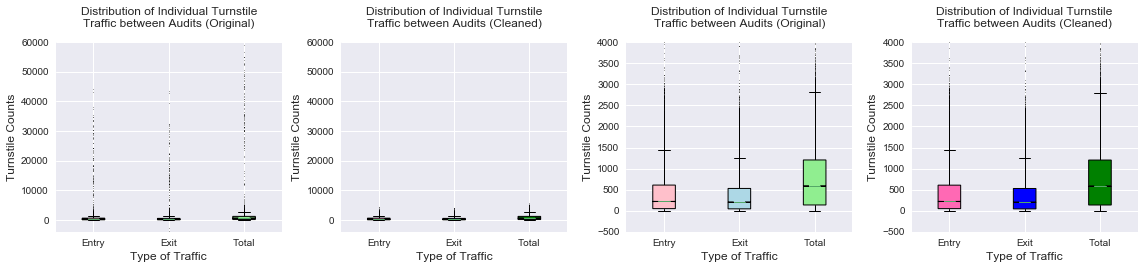

In [27]:
dflist = (df6na.entries_diff,df6na.exits_diff, df6na.sum_traffic)
dfclist = (dfc.entries_diff,dfc.exits_diff, dfc.sum_traffic)
labels = ["Entry", "Exit", "Total"]

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4))

# box plot from matplotlib, showing all data highlighting outliers from the uncleaned dataframes
bplot1 = axes[0].boxplot(dflist,
                         sym = "k.",
                         notch=True,  # notch shape
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         showfliers=True, # show outliers
                         flierprops=dict(color='red'),
                         labels=labels)  # will be used to label x-ticks
axes[0].set_title("\n".join(wrap('Distribution of Individual Turnstile Traffic\
 between Audits (Original)',40))).set_y(1.05)
axes[0].set_ylim(-4000, 60000)

# box plot from matplotlib, showing all data highlighting outliers from the cleaned dataframes
bplot2 = axes[1].boxplot(dfclist,
                         sym = "k.",
                         notch=True,  # notch shape
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         showfliers=True, # show outliers
                         flierprops=dict(markerfacecolor='b', marker='+'),
                         labels=labels)  # will be used to label x-ticks
axes[1].set_title("\n".join(wrap('Distribution of Individual Turnstile Traffic\
 between Audits (Cleaned)',40))).set_y(1.05)
axes[1].set_ylim(-4000, 60000)

#bplot2 = sns.boxplot(x=dflist, y=, hue=, data=dflist, palette="Set1")
bplot3 = axes[2].boxplot(dflist,
                         sym = "k.",
                         notch=True,  # notch shape
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         showfliers=True, # show outliers
                         flierprops=dict(markerfacecolor='b', marker='+'),
                         labels=labels)  # will be used to label x-ticks
axes[2].set_title("\n".join(wrap('Distribution of Individual Turnstile Traffic\
 between Audits (Original)',40))).set_y(1.05)
axes[2].set_ylim(-500, 4000)

bplot4 = axes[3].boxplot(dfclist,
                         sym = "k.",
                         notch=True,  # notch shape
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         showfliers=True, # show outliers
                         flierprops=dict(markerfacecolor='b', marker='+'),
                         labels=labels)  # will be used to label x-ticks
axes[3].set_title("\n".join(wrap('Distribution of Individual Turnstile Traffic\
 between Audits (Cleaned)',40))).set_y(1.05)
axes[3].set_ylim(-500, 4000)

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen','hotpink', 'blue', 'green']
for bplot in (bplot1, bplot3):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

colors2 = ['hotpink', 'blue', 'green']
for bplot in (bplot2, bplot4):
    for patch, color in zip(bplot['boxes'], colors2):
        patch.set_facecolor(color)
           
for bplot in (bplot1,bplot2,bplot3,bplot4):
    plt.setp(bplot['fliers'], markersize=1.0)

# Label axes and title and set limit to axis
# adding horizontal grid lines
for ax in axes:
    ax.yaxis.grid(True)
    ax.set_xlabel('Type of Traffic', fontsize='large')
    ax.set_ylabel('Turnstile Counts', fontsize='large')

fig.tight_layout()
fig.subplots_adjust(top=0.8)
plt.show()

# 5. Exploratory data analysis

## 1a) What's the busiest day of the year?

In [28]:
dfc1 = dfc.groupby('date').entries_diff.sum().sort_values(ascending = False)
# Let's see the top 10 dates with the highest entries.
dfc1.head(10)

date
11/01/2018    129793.0
11/27/2018    121697.0
12/07/2018    120030.0
12/14/2018    118339.0
10/26/2018    115986.0
10/31/2018    115848.0
11/30/2018    115605.0
12/19/2018    115400.0
12/05/2018    115103.0
05/02/2018    114285.0
Name: entries_diff, dtype: float64

In [29]:
#new_df = df.groupby(['user_ID','product_id'], sort=True).sum().reset_index()

In [30]:
dfc2 = dfc1.to_frame().reset_index().copy()
dfc2 = dfc2.sort_values(by='date', ascending=False)
dfc2 = dfc2.reset_index(drop=True).copy()
#column_names3 = list(dfc2.columns.values) 
#print(column_names3)
dfc2.head()

,date,entries_diff
0,12/28/2018,73883.0
1,12/27/2018,78427.0
2,12/26/2018,58882.0
3,12/25/2018,23750.0
4,12/24/2018,65822.0


In [31]:
def busiest_day(df,column):
    df1 = df.groupby('date')[column].sum().sort_values(ascending = False)
    df1 = df1.to_frame().reset_index().copy()
    #print df1.head()
    return df1
    
def traffic_day(df,column):
    df2 = busiest_day(df,column)
    #df2 = df1.to_frame().reset_index().copy()
    df2 = df2.sort_values(by='date', ascending=True)
    df2 = df2.reset_index(drop=True).copy()
    #column_names3 = list(dfc2.columns.values) 
    #print(column_names3)
    return df2


df_traffic = traffic_day(dfc,"entries_diff").join(traffic_day(dfc,"exits_diff").set_index('date'), on='date').\
    join(traffic_day(dfc,"sum_traffic").set_index('date'), on='date')

df_traffic.head(10)

,date,entries_diff,exits_diff,sum_traffic
0,01/01/2018,26631.0,27644.0,54275.0
1,01/02/2018,79228.0,74775.0,154003.0
2,01/03/2018,95694.0,84573.0,180267.0
3,01/04/2018,57595.0,47035.0,104630.0
4,01/05/2018,79183.0,76287.0,155470.0
5,01/06/2018,59397.0,54632.0,114029.0
6,01/07/2018,47054.0,45274.0,92328.0
7,01/08/2018,95095.0,84702.0,179797.0
8,01/09/2018,101023.0,89082.0,190105.0
9,01/10/2018,105556.0,91647.0,197203.0


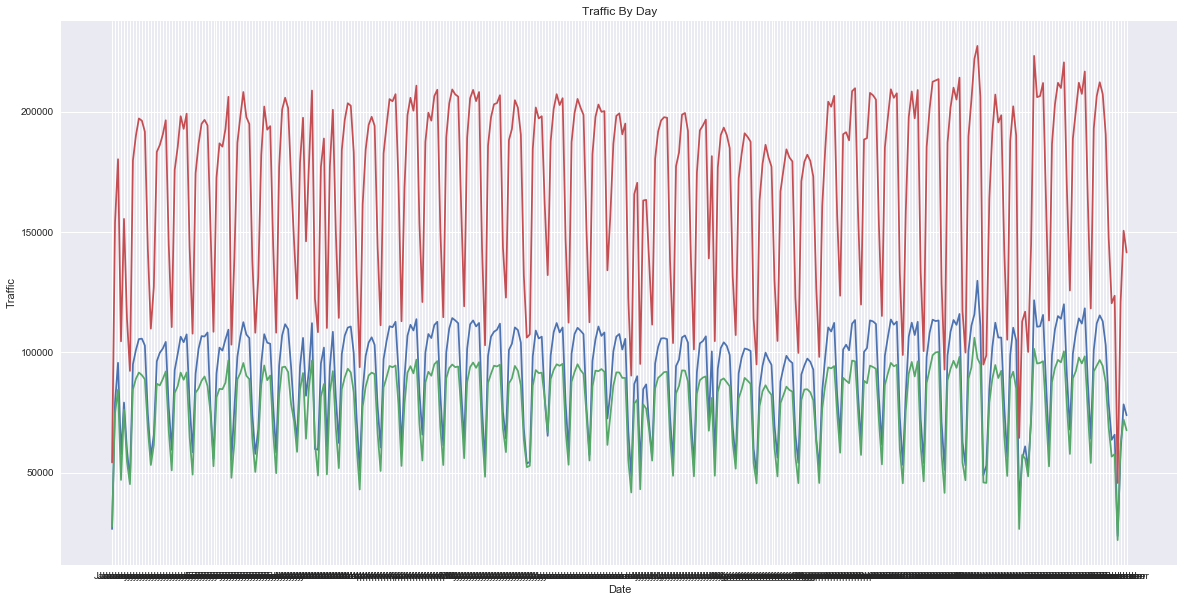

In [125]:
def plottraffic(df, c1):
    return plt.plot(df[c1])
    
#months = mdates.MonthLocator()  # every month

#fig, ax = plt.subplots()
plt.figure(figsize=(20, 10))
ax1 = plottraffic(df_traffic,'entries_diff')
ax2 = plottraffic(df_traffic,'exits_diff')
ax3 = plottraffic(df_traffic, 'sum_traffic')
plt.title('Traffic By Day')
plt.xlabel('Date')
plt.ylabel('Traffic')
# NEED TO FIX LABELS
plt.xticks(np.arange(len(df_traffic['date'])), (df_traffic['date'].apply(lambda x: datetime.datetime.strptime(x,'%m/%d/%Y').strftime('%B'))))
plt.show()


## 1b) What dates have local peaks of traffic?

Text(0,0.5,'Traffic')

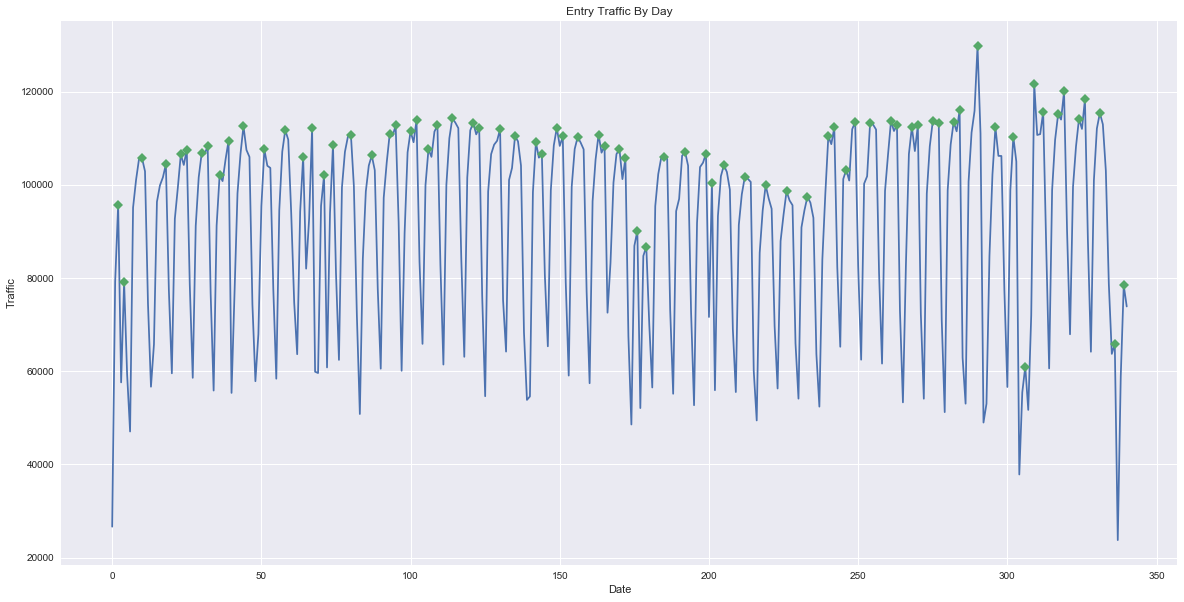

In [126]:
# PUT PEAKS
plt.figure(figsize=(20, 10))
xdf = traffic_day(dfc,"entries_diff")
x = xdf.entries_diff
peaks, _ = find_peaks(x, height=0)
plt.plot(x)
plt.plot(peaks, x[peaks], "D")
df_peaks = xdf.iloc[peaks]
plt.title('Entry Traffic By Day')
plt.xlabel('Date')
plt.ylabel('Traffic')
#df_peaks.head()
#plt.plot(np.zeros_like(x), "--", color="gray")

Text(0,0.5,'Traffic')

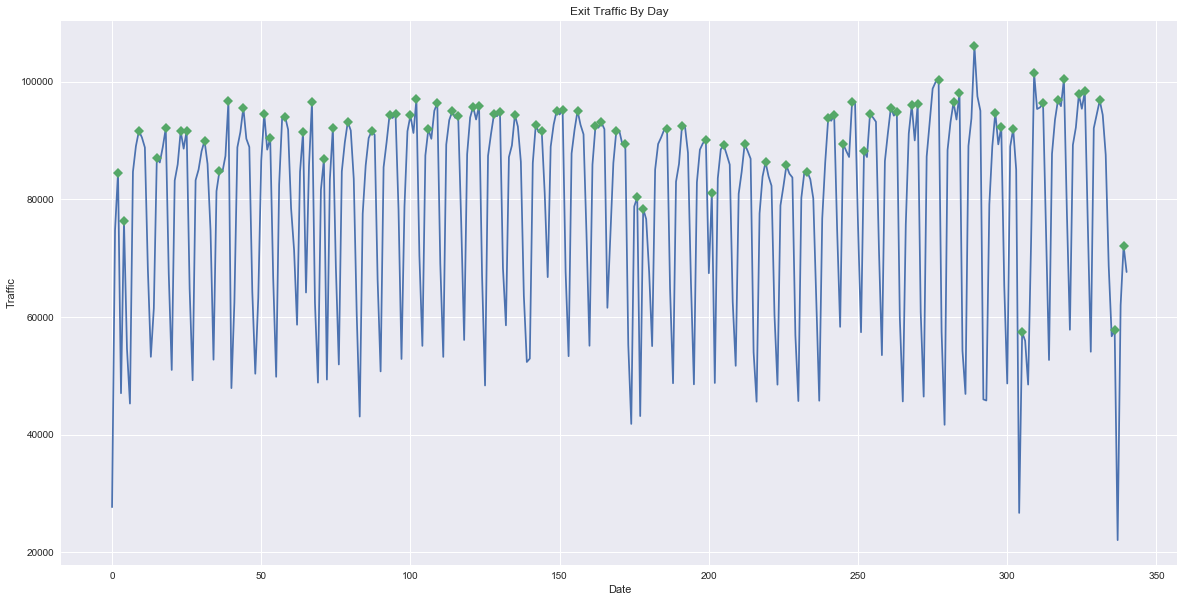

In [127]:
# PUT PEAKS
plt.figure(figsize=(20, 10))
xdf = traffic_day(dfc,"exits_diff")
x = xdf.exits_diff
peaks, _ = find_peaks(x, height=0)
plt.plot(x)
plt.plot(peaks, x[peaks], "D")
df_peaks = xdf.iloc[peaks]
plt.title('Exit Traffic By Day')
plt.xlabel('Date')
plt.ylabel('Traffic')
#plt.plot(np.zeros_like(x), "--", color="gray")

Text(0,0.5,'Traffic')

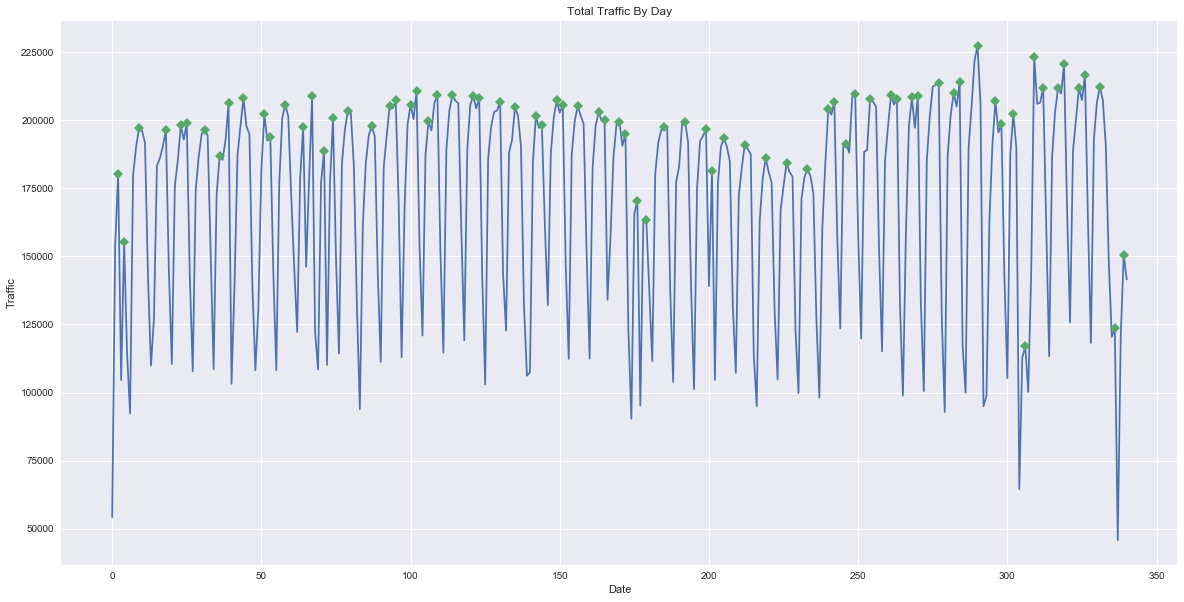

In [128]:
# PUT PEAKS
plt.figure(figsize=(20, 10))
xdf = traffic_day(dfc,"sum_traffic")
x = xdf.sum_traffic
peaks, _ = find_peaks(x, height=0)
plt.plot(x)
plt.plot(peaks, x[peaks], "D")
df_peaks = xdf.iloc[peaks]
plt.title('Total Traffic By Day')
plt.xlabel('Date')
plt.ylabel('Traffic')
#plt.plot(np.zeros_like(x), "--", color="gray")

## 2) What is the distribution of traffic over the course of the day

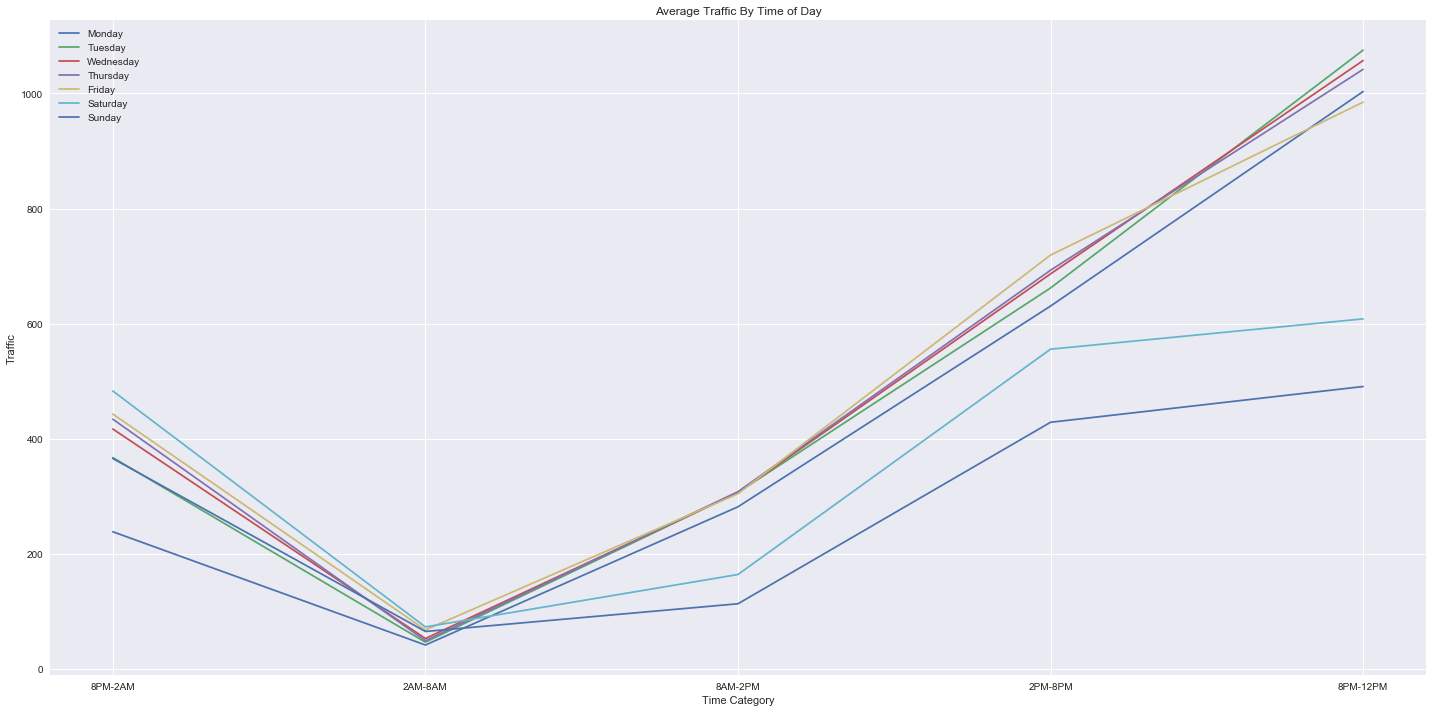

In [136]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
plt.figure(figsize=(20, 10))

## prep data for plotting
a = dfc.groupby(['day_of_week','time_cat'])['entries_diff'].mean()
## generate plot
for i in range(len(days)):
    x = a[days[i]].plot(label = days[i])
plt.legend()

plt.title('Average Traffic By Time of Day')
plt.xlabel('Time Category')
plt.ylabel('Traffic')
plt.xticks(np.arange(0,5),('8PM-2AM','2AM-8AM','8AM-2PM','2PM-8PM','8PM-12PM'))
plt.tight_layout()
plt.show()

In [134]:
a = dfc.groupby(['day_of_week','time_cat'])['entries_diff'].mean()
a

day_of_week  time_cat     
Friday       nightAM           443.085698
             early morning      68.205918
             late morning      304.760397
             afternoon         719.194845
             nightPM           984.839472
Monday       nightAM           238.699285
             early morning      42.007246
             late morning      282.044344
             afternoon         630.640558
             nightPM          1003.277325
Saturday     nightAM           483.204826
             early morning      73.389451
             late morning      164.443750
             afternoon         555.801222
             nightPM           608.414607
Sunday       nightAM           365.909741
             early morning      65.531407
             late morning      113.632810
             afternoon         428.813416
             nightPM           490.941469
Thursday     nightAM           434.194609
             early morning      49.542833
             late morning      308.303653
       

dflist = (dfc.(['day_of_week','time_cat'])['entries_diff'],dfc.exits_diff, dfc.sum_traffic)
dfclist = (dfc.entries_diff,dfc.exits_diff, dfc.sum_traffic)
labels = ["Entry", "Exit", "Total"]

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4))

# box plot from matplotlib, showing all data highlighting outliers from the uncleaned dataframes
bplot1 = axes[0].boxplot(dflist,
                         sym = "k.",
                         notch=True,  # notch shape
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         showfliers=True, # show outliers
                         flierprops=dict(color='red'),
                         labels=labels)  # will be used to label x-ticks
axes[0].set_title("\n".join(wrap('Distribution of Individual Turnstile Traffic\
 between Audits (Original)',40))).set_y(1.05)
axes[0].set_ylim(-4000, 60000)

## 3) Which turnstile had the highest traffic and which day did this high traffic take place?

In [317]:
df11 = df10.copy()
df12 = df11.sort_values(by='entries_per_hr', ascending=False).copy()
# Some time_diff are less than the standard 4 hrs, sometimes 
# within the range of minutes. We will exclude for data points where 
# the time_diff is less than 2 hr.
mask1 = df12['time_diff'] >= 2
df12[mask1].head()

,c_a,unit,scp,date,time,entries,exits,date_time,day_of_week,weekday,year,entries_diff,exits_diff,sum_traffic,time_diff,entries_per_hr,exits_per_hr,traffic_per_hr,time_cat
12292,A033,R170,02-00-05,02/01/2018,20:00:00,13729398,5498557,2018-02-01 20:00:00,Thursday,True,2018,3383.0,108.0,3491.0,4.0,845.75,27.00,872.75,evening
12298,A033,R170,02-00-05,01/31/2018,20:00:00,13721055,5496241,2018-01-31 20:00:00,Wednesday,True,2018,3351.0,105.0,3456.0,4.0,837.75,26.25,864.00,evening
10619,A033,R170,02-00-05,11/29/2018,20:00:00,15431422,6187989,2018-11-29 20:00:00,Thursday,True,2018,3226.0,192.0,3418.0,4.0,806.50,48.00,854.50,evening
12304,A033,R170,02-00-05,01/30/2018,20:00:00,13712847,5493875,2018-01-30 20:00:00,Tuesday,True,2018,3221.0,132.0,3353.0,4.0,805.25,33.00,838.25,evening
12262,A033,R170,02-00-05,02/06/2018,20:00:00,13761214,5509129,2018-02-06 20:00:00,Tuesday,True,2018,3176.0,153.0,3329.0,4.0,794.00,38.25,832.25,evening


The top five entries per hr all take place with the same turnstile (C/A A033, Unit R170, SCP 02-00-05). All of them occur between the 4:00 PM - 8:00 PM slots

In [318]:
# Let's repeat the process for the exits
df13 = df11.sort_values(by='exits_per_hr', ascending=False).copy()
mask2 = df13['time_diff'] >= 2
df13[mask2].head()

,c_a,unit,scp,date,time,entries,exits,date_time,day_of_week,weekday,year,entries_diff,exits_diff,sum_traffic,time_diff,entries_per_hr,exits_per_hr,traffic_per_hr,time_cat
17087,A034,R170,03-00-00,10/19/2018,21:00:00,1882267,14427387,2018-10-19 21:00:00,Friday,True,2018,177.0,3332.0,3509.0,4.0,44.25,833.00,877.25,evening
17011,A034,R170,03-00-00,10/31/2018,21:00:00,1890024,14502602,2018-10-31 21:00:00,Wednesday,True,2018,375.0,3324.0,3699.0,4.0,93.75,831.00,924.75,evening
17745,A034,R170,03-00-00,06/24/2018,17:00:00,1803452,13727884,2018-06-24 17:00:00,Sunday,False,2018,445.0,2965.0,3410.0,4.0,111.25,741.25,852.50,afternoon
16791,A034,R170,03-00-00,12/14/2018,20:00:00,1915974,14769798,2018-12-14 20:00:00,Friday,True,2018,237.0,2901.0,3138.0,4.0,59.25,725.25,784.50,evening
16832,A034,R170,03-00-00,12/07/2018,20:00:00,1911781,14722903,2018-12-07 20:00:00,Friday,True,2018,235.0,2888.0,3123.0,4.0,58.75,722.00,780.75,evening


The top five exits per hr all take place with the same turnstile (C/A A033, Unit R170, SCP 03-00-00). This traffic mostly took place mostly during the 4PM-9PM slots. We notice that Sunday 6/24/18 has heightened exit traffic during the 1PM-5PM time slot - this coincides nicely with timing of the NYC Pride March that took place that day.

In [321]:
# Let's repeat the process for sum_traffic
df14 = df11.sort_values(by='traffic_per_hr', ascending=False)
mask3 = df14['time_diff'] >= 2
df14[mask3].head()

,c_a,unit,scp,date,time,entries,exits,date_time,day_of_week,weekday,year,entries_diff,exits_diff,sum_traffic,time_diff,entries_per_hr,exits_per_hr,traffic_per_hr,time_cat
17011,A034,R170,03-00-00,10/31/2018,21:00:00,1890024,14502602,2018-10-31 21:00:00,Wednesday,True,2018,375.0,3324.0,3699.0,4.0,93.75,831.00,924.75,evening
17087,A034,R170,03-00-00,10/19/2018,21:00:00,1882267,14427387,2018-10-19 21:00:00,Friday,True,2018,177.0,3332.0,3509.0,4.0,44.25,833.00,877.25,evening
12292,A033,R170,02-00-05,02/01/2018,20:00:00,13729398,5498557,2018-02-01 20:00:00,Thursday,True,2018,3383.0,108.0,3491.0,4.0,845.75,27.00,872.75,evening
12298,A033,R170,02-00-05,01/31/2018,20:00:00,13721055,5496241,2018-01-31 20:00:00,Wednesday,True,2018,3351.0,105.0,3456.0,4.0,837.75,26.25,864.00,evening
10619,A033,R170,02-00-05,11/29/2018,20:00:00,15431422,6187989,2018-11-29 20:00:00,Thursday,True,2018,3226.0,192.0,3418.0,4.0,806.50,48.00,854.50,evening


In [320]:
#fig, ax = plt.subplots(figsize=(15,5))

#plt.subplot(1, 3, 1)
#plt.plot(df12[mask1][:5]['entries_per_hr'].sort_values(ascending=False),(kind='bar', ax=ax)
    #y = 'scp' + ' ' + 'date_time'
#ax.set_xlabel('Average Entries Rates')
#ax.set_ylabel('Time and Place')
#ax.set_title('Busiest Turnstiles')

#plt.subplot(1, 3, 2)
#df13[mask2][:5]['exits_per_hr'].sort_values(ascending=False).plot\
#    (kind='bar', ax=ax)
#ax.set_xlabel('Average Exits Rates')
#ax.set_ylabel('Time and Place')
#ax.set_title('Busiest Turnstiles')

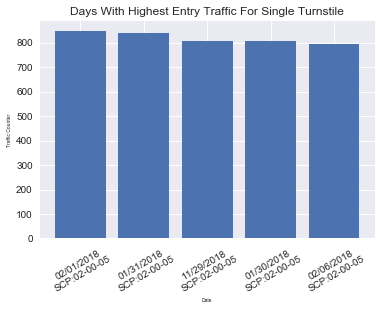

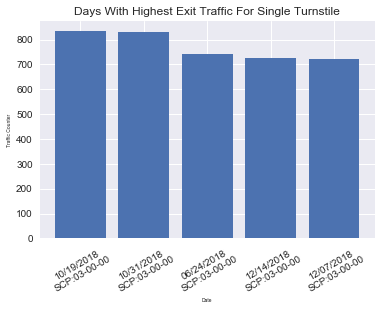

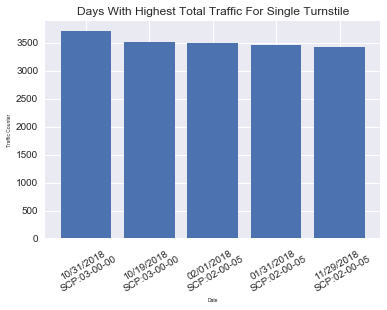

In [360]:
def barplot_date(df,mask,top,column,xlabel,ylabel,title):
    # this is for plotting purpose
    y = df[mask][:top][column]
    plt.bar(np.arange(len(y)),y)
    plt.xlabel(xlabel, fontsize=5)
    plt.ylabel(ylabel, fontsize=5)
    plt.xticks(np.arange(len(y)),(df[mask]['date'] + "\n" + "SCP:" + df[mask]['scp']), fontsize=10, rotation=30)
    plt.title(title)
    plt.show()
#
barplot_date(df12,
             mask1,
             5,
             'entries_per_hr',
             'Date',
             'Traffic Counter',
             'Days With Highest Entry Traffic For Single Turnstile')

barplot_date(df13,
             mask2,
             5,
             'exits_per_hr',
             'Date',
             'Traffic Counter',
             'Days With Highest Exit Traffic For Single Turnstile')

barplot_date(df14,
             mask3,
             5,
             'sum_traffic',
             'Date',
             'Traffic Counter',
             'Days With Highest Total Traffic For Single Turnstile')


# END